In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy.modeling.models import Gaussian2D
import matplotlib.pyplot as plt

output_dir = 'fits_data'
n_frames = 30
image_shape = (300, 300)
star_position = (150, 150)  # (x, y)
background_mean = 100
background_std = 5
star_sigma = 2.5
flux_amplitude_range = (500, 1000)
np.random.seed(42)  # Reproducibility

os.makedirs(output_dir, exist_ok=True)

# --- Generate and save synthetic frames ---
for i in range(n_frames):
    # Background noise
    data = np.random.normal(loc=background_mean, scale=background_std, size=image_shape)
    
    # Variable star brightness (sinusoidal or random)
    flux = np.random.uniform(*flux_amplitude_range)
    
    # Gaussian point source
    gauss = Gaussian2D(amplitude=flux, x_mean=star_position[0], y_mean=star_position[1],
                       x_stddev=star_sigma, y_stddev=star_sigma)
    y, x = np.mgrid[0:image_shape[0], 0:image_shape[1]]
    star = gauss(x, y)
    
    # Add star to image
    data += star

    # Save to FITS
    hdu = fits.PrimaryHDU(data)
    hdu.writeto(os.path.join(output_dir, f'frame_{i:03d}.fits'), overwrite=True)

print(f"✅ {n_frames} synthetic FITS files created in '{output_dir}/'.")

✅ 30 synthetic FITS files created in 'fits_data/'.


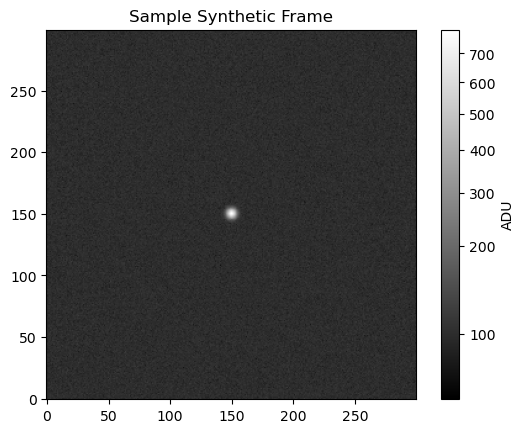

In [2]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

sample_file = os.path.join(output_dir, 'frame_000.fits')
with fits.open(sample_file) as hdul:
    data = hdul[0].data

norm = simple_norm(data, 'sqrt')
plt.imshow(data, origin='lower', cmap='gray', norm=norm)
plt.title('Sample Synthetic Frame')
plt.colorbar(label='ADU')
plt.show()

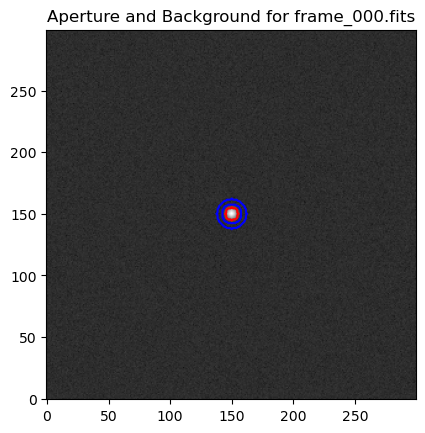

Photometry Results:
frame_000.fits: Flux = 23193.86
frame_001.fits: Flux = 24714.30
frame_002.fits: Flux = 26507.29
frame_003.fits: Flux = 26294.55
frame_004.fits: Flux = 19698.20
frame_005.fits: Flux = 23037.60
frame_006.fits: Flux = 32067.81
frame_007.fits: Flux = 21220.78
frame_008.fits: Flux = 20213.69
frame_009.fits: Flux = 32341.25
frame_010.fits: Flux = 31301.23
frame_011.fits: Flux = 24857.96
frame_012.fits: Flux = 23008.45
frame_013.fits: Flux = 23487.42
frame_014.fits: Flux = 29849.28
frame_015.fits: Flux = 33331.31
frame_016.fits: Flux = 23198.92
frame_017.fits: Flux = 22191.27
frame_018.fits: Flux = 25724.01
frame_019.fits: Flux = 22350.46
frame_020.fits: Flux = 21168.71
frame_021.fits: Flux = 25666.32
frame_022.fits: Flux = 31803.86
frame_023.fits: Flux = 20260.06
frame_024.fits: Flux = 20926.79
frame_025.fits: Flux = 20137.44
frame_026.fits: Flux = 22790.05
frame_027.fits: Flux = 28630.67
frame_028.fits: Flux = 32552.10
frame_029.fits: Flux = 22959.26


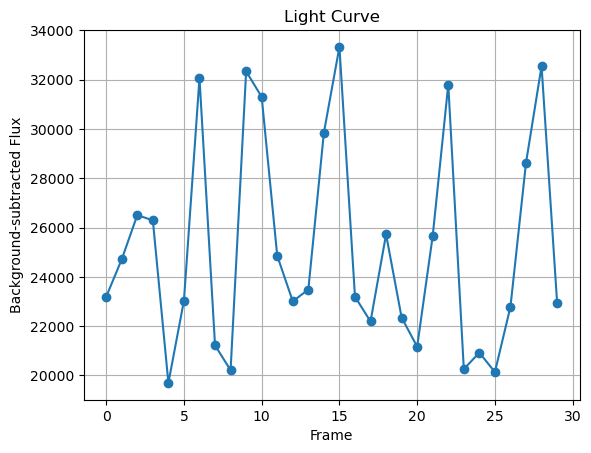

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm

# --- CONFIG ---
data_folder = 'fits_data/'          # Folder containing FITS files
position = (150, 150)               # Star position (x, y) in pixels
aperture_radius = 5                 # Aperture radius
annulus_r_in = 8                    # Inner radius of background annulus
annulus_r_out = 12                  # Outer radius of background annulus

# --- Helper: Create circular mask ---
def circular_mask(shape, center, radius):
    yy, xx = np.indices(shape)
    r = np.sqrt((xx - center[0])**2 + (yy - center[1])**2)
    return r <= radius

def annulus_mask(shape, center, r_in, r_out):
    yy, xx = np.indices(shape)
    r = np.sqrt((xx - center[0])**2 + (yy - center[1])**2)
    return (r >= r_in) & (r <= r_out)

# --- Get list of FITS files ---
fits_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.fits')])
results = []

for file in fits_files:
    filepath = os.path.join(data_folder, file)
    with fits.open(filepath) as hdul:
        data = hdul[0].data.astype(float)

    # Generate masks
    aperture = circular_mask(data.shape, position, aperture_radius)
    annulus = annulus_mask(data.shape, position, annulus_r_in, annulus_r_out)

    # Sum signal and estimate background
    aperture_sum = data[aperture].sum()
    bkg_median = np.median(data[annulus])
    bkg_total = bkg_median * aperture.sum()
    net_flux = aperture_sum - bkg_total

    results.append({
        'file': file,
        'flux': net_flux
    })

    # Visualize the first frame
    if file == fits_files[0]:
        norm = simple_norm(data, 'sqrt')
        plt.imshow(data, cmap='gray', origin='lower', norm=norm)
        yy, xx = np.indices(data.shape)
        plt.contour(aperture, [0.5], colors='red')
        plt.contour(annulus, [0.5], colors='blue')
        plt.title(f'Aperture and Background for {file}')
        plt.show()

# --- Print and plot light curve ---
print("Photometry Results:")
for res in results:
    print(f"{res['file']}: Flux = {res['flux']:.2f}")

# Light curve
plt.figure()
plt.plot([r['flux'] for r in results], marker='o')
plt.xlabel('Frame')
plt.ylabel('Background-subtracted Flux')
plt.title('Light Curve')
plt.grid(True)
plt.show()
